In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.datasets import imdb
from keras.utils import pad_sequences

Define the Transformer Block

In [2]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate = 0.1):
        # embed_dim: this parameter specifies the dimensions of the the input and output
        # num_heads: controls the numbers of attentions heads n the multi
        # ff_dim: specifies the dimensionality of the feedforward network
        # rate: controls the dropout rate, which to used for regularization

        super().__init__() 
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # This creates the a MultiHeadAttention layer, responsible for learning long range
        self.ffn = Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim), 
        ])
        # This for additional normalization
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        # self.layernorm1 and layernorm2 create LayerNormalization layers
        
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output= self.att(inputs, inputs)
        # applies mulit-head atttention to input sequence allowing different part
        
        attn_output = self.dropout1(attn_output, training=training)
        # Applies dropout layer to attention output
        
        out1 = self.layernorm1(inputs+attn_output)
        # Adds the attentions output to the original input and applies layer normalization

        # Passes the normalized output through Feed-Forward Network
        ffn_output = self.ffn(out1)

        # Applies dropout to Feed-Forward output
        ffn_output = self.dropout2(ffn_output, training = training)

        return self.layernorm2(out1 + ffn_output)

In [12]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        # maxlem: max len of the input sequence
        # vocab_size: total no. of unique token in vocab
        # embed_size: dimension of embedding

        super().__init__()
        # embedding layer that maps each token in the input sequence to a dense vector of size embed_dim
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # embedding layer that maps each token in the input sequence (from 0 to maxlen - 1) to a dense vector of size embed_dim 
        self.pos_emb = Embedding(input_dim=maxlen, output_dim= embed_dim)


    def call(self, x):
        # Extract the actual length of the current input sequence
        maxlen = tf.shape(x)[-1]
        # creates a tensor of positions from 0 to maxlen - 1
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # Looks up the positions embeddings for each positions in the sequence
        positions = self.pos_emb(positions)
        # Looks up the positions embeddings for each positions in the sequence
        x = self.token_emb(x)

        # Adds the token embeddings and position embeddings element wise resulting in  a combined representation that captures both word meaning and positional information
        return x + positions

In [4]:
vocab_size = 2000 # Only consider the top 20k words
maxlen = 200 # only consider the first 200 words of each movie review

In [5]:
(x_train, y_train), (x_val, y_val) = imdb.load_data(num_words=vocab_size)

In [6]:
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")


25000 Training sequences
25000 Validation sequences


In [7]:
x_train = pad_sequences(x_train, maxlen= maxlen)
x_val = pad_sequences(x_val, maxlen= maxlen)

In [8]:
x_train.shape

(25000, 200)

In [9]:
x_val.shape

(25000, 200)

In [10]:
x_train[4000]

array([  89,    8,  511,    2,   59,    2,   41,  523,  147, 1876,    5,
          2,  175,  347,   11,  618,    4,  172,   96,    2,    2,    9,
        862,    2,    8,   41,    5,   27,  532,    2,    9,    2,    4,
          2,  136,    2,    2,    5,    2,   19, 1456,  921,   42,    2,
       1488,   68,    2,  216,   17,    6,    2,   48,   13,   69,    6,
          2,   13,   62,   28,    2,   12,    8,   98,  634,  908,   10,
         10,    2,    2,    9,    2,   17,    2,    6,   87, 1465,   48,
         25,  377,   27,  478,  157,   11,    2,    2,   29,    2,    4,
          2,    7,    2,    2,   83,    6,    2,    2,    7,  107,   42,
        289,  715,  257,    5,   95,    2,    4,    2,   11,   17,    2,
          5,    2, 1377,   17,  614,   11,   14,  365, 1652,    2,    2,
        373,   10,   10,    4,  167,    2,    2,  287,   64,   35,    2,
          2,    7, 1489,    4,  370,  121,   12,   80,  123,  178,   51,
         75,  181,    8,   67,    4,  636,    2,   

In [13]:
embed_dim = 32
num_heads = 2
ff_dim = 32

inputs = Input(shape=(maxlen, ))

embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)

x = embedding_layer(inputs)

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)

x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation= 'relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(2, activation= 'softmax')(x)

model = Model(inputs= inputs, outputs= outputs)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddi  (None, 200, 32)           70400     
 ng_1 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block (Transfo  (None, 200, 32)           10656     
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

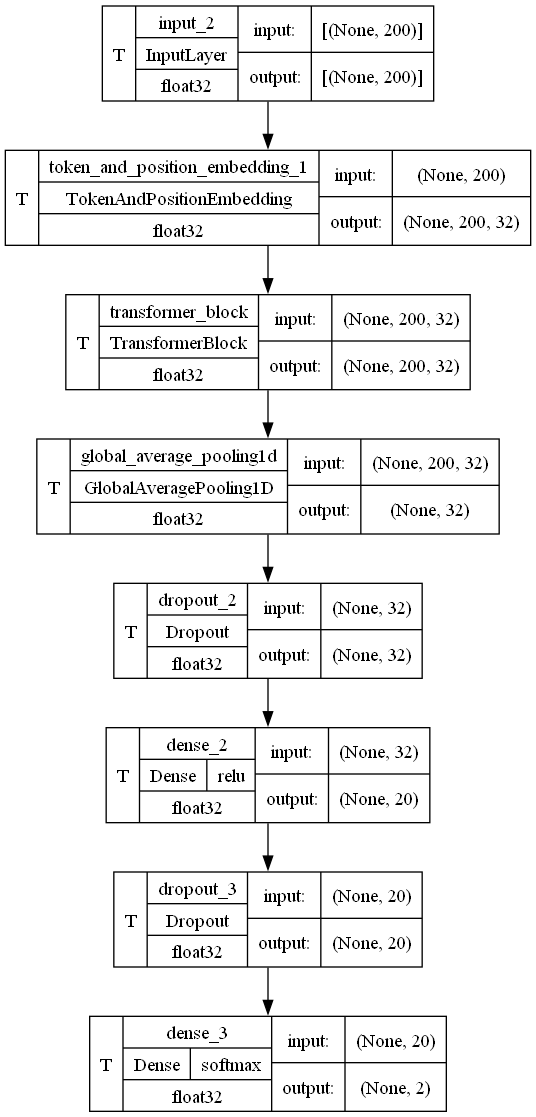

In [23]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True, show_trainable=True, expand_nested=True, )

Compile the Model

In [18]:
model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', 
              metrics=['accuracy'])

Train the Model

In [16]:
history = model.fit(x_train, y_train, batch_size= 32, epochs= 10, 
                    validation_data=(x_val, y_val))

Epoch 1/10


782/782 [==============================] - 40s 47ms/step - loss: 0.4181 - accuracy: 0.7957 - val_loss: 0.3035 - val_accuracy: 0.8680
Epoch 2/10
782/782 [==============================] - 36s 45ms/step - loss: 0.2983 - accuracy: 0.8765 - val_loss: 0.2986 - val_accuracy: 0.8729
Epoch 3/10
782/782 [==============================] - 35s 45ms/step - loss: 0.2806 - accuracy: 0.8860 - val_loss: 0.3111 - val_accuracy: 0.8674
Epoch 4/10
782/782 [==============================] - 35s 45ms/step - loss: 0.2689 - accuracy: 0.8894 - val_loss: 0.3146 - val_accuracy: 0.8608
Epoch 5/10
782/782 [==============================] - 35s 45ms/step - loss: 0.2614 - accuracy: 0.8913 - val_loss: 0.3116 - val_accuracy: 0.8656
Epoch 6/10
782/782 [==============================] - 36s 46ms/step - loss: 0.2491 - accuracy: 0.8952 - val_loss: 0.3210 - val_accuracy: 0.8639
Epoch 7/10
782/782 [==============================] - 36s 46ms/step - loss: 0.2384 - accuracy: 0.8941 - val_loss: 0.3710 - val_accurac

In [ ]:
# mi p
